# STA160 Data Science 2021 Spring

# Part4- Classification Framework and Classifier

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn import datasets
# import some data to play with
iris = datasets.load_iris()

In [3]:
# show data in Pandas DataFrame
iris_data=pd.DataFrame(iris.data,columns=iris['feature_names'])
iris_data['species']=iris.target
target_map=dict(enumerate(iris['target_names'])) # insert names of species
iris_data['species']=iris_data['species'].map(target_map)
iris_data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [4]:
# keep data in Numpy Arrays
X=iris.data
Y=iris.target

## Train & test splitting

In [5]:
# random sampling
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = \
train_test_split(X, Y, test_size=0.3, random_state=10)

In [6]:
pd.value_counts(Y_train)/len(Y_train)

2    0.342857
0    0.342857
1    0.314286
dtype: float64

In [7]:
# stratified sampling based on the species
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=100)
for train_index, test_index in split.split(X,Y):
    X_train_strat, Y_train_strat = X[train_index], Y[train_index]
    X_test_strat, Y_test_strat = X[test_index], Y[test_index]

In [8]:
pd.value_counts(Y_train_strat)/len(Y_train_strat)

2    0.333333
1    0.333333
0    0.333333
dtype: float64

## Cross-Validation
Split training set into training and validation sets.

Data= Traning + Test

Data= training + validation + test

In [9]:
# Let's use Random Forest as a Classifier
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Generate cross-validated estimates for each input data point
# Each sample belongs to exactly one validate set, and its prediction is computed 
# with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

tree=RandomForestClassifier()
cv_prob=cross_val_predict(tree, X_train_strat, Y_train_strat, cv=10, method='predict_proba') #make sure it can 'predict_proba'
cv_prob[:5]

array([[0.  , 1.  , 0.  ],
       [0.  , 0.97, 0.03],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.84, 0.16, 0.  ]])

In [11]:
# Instead of returning probability results, we can also obtain Classification accuracy for each splitted validate fold
from sklearn.model_selection import cross_val_score

tree=RandomForestClassifier()
scores=cross_val_score(tree, X_train_strat, Y_train_strat, cv=10, scoring='accuracy')

In [12]:
scores

array([0.90909091, 0.81818182, 1.        , 1.        , 0.90909091,
       0.9       , 1.        , 1.        , 1.        , 0.9       ])

In [13]:
print(scores.mean(), scores.std())

0.9436363636363637 0.06149648918286458


In [14]:
# Stratified Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score

tree=RandomForestClassifier()

scv_result=[]
scv=StratifiedKFold(n_splits=10) # iterate 10 times

for train_index, valid_index in scv.split(X_train_strat,Y_train_strat):
    X_train_fold, Y_train_fold = X_train_strat[train_index], Y_train_strat[train_index]
    X_valid_fold, Y_valid_fold = X_train_strat[valid_index], Y_train_strat[valid_index]
    
    tree_clone=clone(tree) # clone a new classifier
    tree_clone.fit(X_train_fold, Y_train_fold)
    valid_pred=tree_clone.predict(X_valid_fold)
    scv_result.append(accuracy_score(Y_valid_fold, valid_pred))

In [15]:
print(np.mean(scv_result), np.std(scv_result))

0.9436363636363637 0.06149648918286458


### write your own CV

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

n=X.shape[0]
cv=5

tree=RandomForestClassifier()
acc=[]

for i in range(cv):
    index=np.in1d(range(n),range(i*(n//cv),(i+1)*(n//cv))) # bool: True or False
    X_tain, Y_train=X[~index], Y[~index]
    X_valid, Y_valid=X[index], Y[index]
    tree_clone=clone(tree)
    tree_clone.fit(X_tain, Y_train)
    Y_predict=tree_clone.predict(X_valid)
    acc.append(sum(Y_predict==Y_valid)/len(Y_valid))
    
np.mean(acc)

0.9066666666666666

## Grid Search
Search for the best parameter combination.

Here we apply grad-search + cross-validation in the training set.

In [17]:
RandomForestClassifier?

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid=[{'n_estimators':[3, 10, 30], 'max_features':[1,2,3,4],'bootstrap':[True,False]}]
tree=RandomForestClassifier()
grid_search=GridSearchCV(tree, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train_strat, Y_train_strat)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [19]:
grid_search.best_params_

{'bootstrap': True, 'max_features': 3, 'n_estimators': 3}

In [20]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
grid_search.best_score_

0.9618181818181819

In [22]:
result=pd.DataFrame(grid_search.cv_results_['params'])
result['accuracy']=grid_search.cv_results_['mean_test_score']
result.sort_values('accuracy', ascending=False)

,bootstrap,max_features,n_estimators,accuracy
6,True,3,3,0.961818
14,False,1,30,0.952727
23,False,4,30,0.943636
10,True,4,10,0.943636
17,False,2,30,0.943636
16,False,2,10,0.943636
15,False,2,3,0.943636
13,False,1,10,0.943636
1,True,1,10,0.943636
11,True,4,30,0.943636


In [23]:
# classification result in test set
from sklearn.metrics import accuracy_score

final_model=grid_search.best_estimator_
test_final_pred=final_model.predict(X_test_strat)
accuracy_score(Y_test_strat, test_final_pred)

0.9333333333333333

### Randomized Search
Instead of searching for all the combinations of parameters, we can use randomizede search for the timming.

In [24]:
from sklearn.model_selection import RandomizedSearchCV

param_grid=[{'n_estimators':[3, 10, 30, 50], 'max_features':[1,2,3,4],'bootstrap':[True,False]}]
tree=RandomForestClassifier()
random_search=RandomizedSearchCV(tree, param_grid, n_iter=10, cv=10, scoring='accuracy')
random_search.fit(X_train_strat, Y_train_strat)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [25]:
result2=pd.DataFrame(random_search.cv_results_['params'])
result2['accuracy']=random_search.cv_results_['mean_test_score']
result2.sort_values('accuracy', ascending=False)

,n_estimators,max_features,bootstrap,accuracy
0,3,3,True,0.943636
1,3,4,True,0.943636
2,50,1,False,0.943636
4,50,4,True,0.943636
5,30,4,True,0.943636
6,3,2,True,0.943636
7,10,4,False,0.943636
8,50,2,False,0.943636
9,30,3,False,0.943636
3,3,3,False,0.933636


## Confusion Matrix

the count of true negatives is :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, 
true positives is:math:`C_{1,1}` and false positives is :math:`C_{0,1}`

In [26]:
from sklearn.metrics import confusion_matrix
test_final_pred=final_model.predict(X_test_strat)
conf=confusion_matrix(Y_test_strat, test_final_pred)
conf

array([[15,  0,  0],
       [ 0, 15,  0],
       [ 0,  3, 12]])

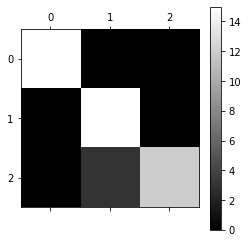

In [53]:
import matplotlib.pyplot as plt
plt.matshow(conf, cmap=plt.cm.gray)
plt.colorbar();

In [28]:
row_sums=conf.sum(axis=1, keepdims=True)
norm_conf=conf/row_sums
norm_conf

array([[1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0.2, 0.8]])

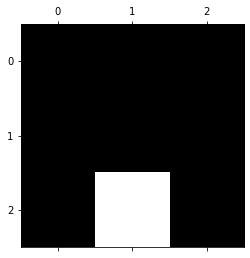

In [29]:
# error plot
np.fill_diagonal(norm_conf,0) # only keep the errors
plt.matshow(norm_conf, cmap=plt.cm.gray);

In [30]:
# Return predicted probabilities; Actually, the decision is made by pick the class with the highest probability.
test_final_prob=final_model.predict_proba(X_test_strat)
test_final_prob[:5]

array([[1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.66666667],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ]])

For Binary Classification, we can also calculate Precision and Recall, see __precision_score()__, __recall_score()__.

Furthermore, the Precision-Recall and ROC curves can be plot via __precision_recall_curve()__, __roc_curve()__.

    from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve

## Multiclass Classification
Some algorithm, such as RandomForest are capable of handing mutltiple classes directly. Others are strictly binary classifiers. However, there are various strategies that you can still perform multiclass classification.

### one-versus-rest
Also known as one-vs-all, this strategy consists in fitting one classifier
per class. For each classifier, the class is fitted against all the other
classes. In addition to its computational efficiency (only `n_classes`
classifiers are needed), one advantage of this approach is its
interpretability. Since each class is represented by one and one classifier
only, it is possible to gain knowledge about the class by inspecting its
corresponding classifier. This is the most commonly used strategy for
multiclass classification and is a fair default choice.

### one-versus-one
This strategy consists in fitting one classifier per class pair.
At prediction time, the class which received the most votes is selected.
Since it requires to fit `n_classes * (n_classes - 1) / 2` classifiers,
this method is usually slower than one-vs-the-rest, due to its
O(n_classes^2) complexity. However, this method may be advantageous for
algorithms such as kernel algorithms which don't scale well with
`n_samples`. This is because each individual learning problem only involves
a small subset of the data whereas, with one-vs-the-rest, the complete
dataset is used `n_classes` times.

    from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

#### Note: Sample Split, Cross-Validation, Grid-Search, Confusion Matrix, Multi-Class - all the tricks above can be implemented with all the classifiers that will be covered next and in the future. Just for simplicity, in the next section we just use the whole data set to train classifiers.

## Classifier: Logistic Regression and SVM

## Logistic Regression

$$p_i=p(x_i)=\sigma(x_{i}^T \beta)$$
$x$ is a sample with $p$ features; $\beta$ is a $p$-dim parameter vector. 

$\sigma(x)$ is logit or sigmoid function that out puts a number between 0 and 1,
$\sigma(x)=\frac{e^{x}}{1+e^x}$

so, $$p(x)=\frac{e^{x^T \beta}}{1+e^{x^T \beta}}$$

Loss function: negative MLE
    
$$L(\beta) = - \frac{1}{n} \sum_{i=1}^{n} Y_ilog(p_i) + (1-Y_i)log(1-p_i) $$

Prediction:

$$\hat{p}_i=\sigma(x_{i}^T \hat{\beta})$$

Decision:

if $\hat{p}_i$ > 0.5, classify $x_i$ to label "1"; else, "0".

Let's define a Binary class and implement Logistic regression.

In [31]:
y_virginica=(iris['target']==2).astype('int') # 1 if virginica else 0

### 1-D Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

petal_width=iris['data'][:,3:] # petal width

logit1D=LogisticRegression(penalty='none') # penalty can be LASSO or Ridge
logit1D.fit(petal_width,y_virginica)

x_new=np.linspace(0,3,100).reshape(-1,1)
y_new_pred=logit1D.predict(x_new)
y_new_proba=logit1D.predict_proba(x_new)

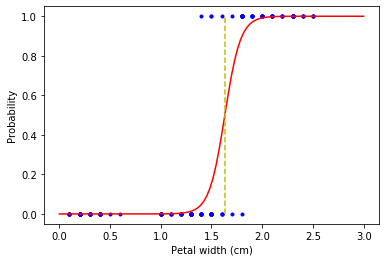

In [33]:
plt.plot(petal_width, y_virginica, 'b.')
plt.plot(x_new, y_new_proba[:,1], 'r-')
plt.plot([1.63163742,1.63163742], [0,1], 'y--')
plt.xlabel('Petal width (cm)')
plt.ylabel('Probability')
plt.show()

In [35]:
# if x > thresh, p_hat > 0.5, predict 1; otherwise, predict 0
-logit1D.intercept_/logit1D.coef_

array([[1.63163742]])

### 2-D Logistic Regression

In [36]:
petal_len_wid=iris['data'][:,2:] # petal length + petal width
logit2D=LogisticRegression(penalty='none')
logit2D.fit(petal_len_wid,y_virginica)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
# Plotting 2-D decision regions
def decision_region(X, Y, model, prob=None):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                         np.arange(x2_min, x2_max, 0.1))

    Z = model.predict(np.c_[x1.ravel(), x2.ravel()])
    
    if prob is not None:
        prob_max=model.predict_proba(np.c_[x1.ravel(), x2.ravel()]).max(1)
        Z[prob_max<prob]=-1
    
    Z = Z.reshape(x1.shape)

    plt.contourf(x1, x2, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    plt.show()

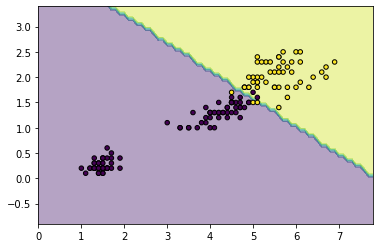

In [38]:
decision_region(petal_len_wid, y_virginica, logit2D)

### Multi-class Logistic Regression (continue 2-D example)

#### One-vs-Rest

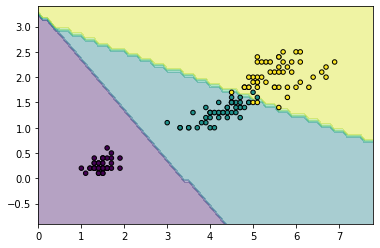

In [39]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

logit1=OneVsRestClassifier(LogisticRegression(penalty='none'))
logit1.fit(petal_len_wid,Y)
decision_region(petal_len_wid,Y,logit1)

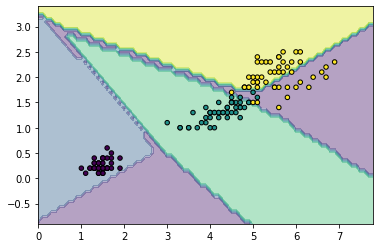

In [40]:
# if the predicted probability is less than 0.7, which means the classifier is not confident to predict,
# make the region in a new color
decision_region(petal_len_wid,Y,logit1,prob=0.7)

#### One-vs-One

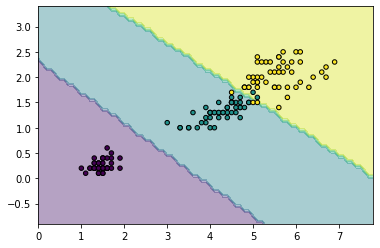

In [41]:
logit2=OneVsOneClassifier(LogisticRegression(penalty='none'))
logit2.fit(petal_len_wid,Y)
decision_region(petal_len_wid,Y,logit2)

### Multinomial Logistic Regression
First, compute a score $s_k$ for each class $k$,
$$s_k(x)=x^T \beta_{k}$$

Then, estimate the probability of each class $p_k$ by applying the softmax function to the scores.
$$p_k=\frac{exp(s_k(x))}{\sum_{j=1}^{K}exp(s_j(x))}$$
$K$ is the number of classes. Note: $\sum_{1}^{K}p_k = 1$.

Loss function: Cross Entropy
$$L(\beta)=-\frac{1}{n}\sum_{i=1}^{n}\sum_{k=1}^{K} Y_k^i log(p_k^i)$$

Decision:

$$\hat{y} = argmax_k \hat{p_k} = argmax_k \hat{s_k}(x)$$



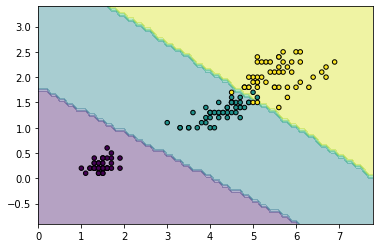

In [42]:
logit3=LogisticRegression(penalty='none', multi_class='multinomial')
logit3.fit(petal_len_wid,Y)
decision_region(petal_len_wid,Y,logit3)

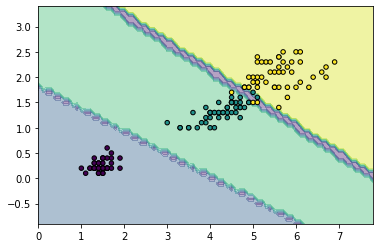

In [43]:
decision_region(petal_len_wid,Y,logit3,prob=0.7)

## SVM

__Hard-margin__:

If the training data is linearly separable, we can select two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible. The region bounded by these two hyperplanes is called the "margin", and the maximum-margin hyperplane is the hyperplane that lies halfway between them.

Geometrically, the distance between these two hyperplanes is 
$\frac {2}{\|{\vec {w}}\|}$, so to maximize the distance between the planes we want to minimize $\|{\vec {w}}\|$.

Add constraints: 

$$w*x-b \ge 1 , \,\, if \,\, y = 1$$
$$w*x-b \le -1 , \,\, if \,\, y = -1$$

So,

   Minimize $\|{\vec {w}}\|$ subject to $y_i(w*x_i-b) \ge 1$ for $i=1,2,...,n$.



__Soft-margin__:

To extend SVM to cases in which the data are not linearly separable, we introduce the hinge loss function,
$$max(0,1-y_i(w*x_i-b))$$

Loss function:

$$\frac{1}{n}\sum_{i=1}^n max(0,1-y_i(w*x_i-b)) + \lambda \|{w}\|$$

where the parameter $\lambda$  determines the trade-off between increasing the margin size and ensuring that the 
$x_i$ lie on the correct side of the margin. In `sklearn`, it uses $C = 1/\lambda$ to control the balance. For sufficiently large values of $C$ , the second term in the loss function will become negligible, hence, it will behave similar to the hard-margin SVM; A smaller $C$ leads to a wider cutting lines but more margin violations. If your SVM is overfitting, you can try to regularize it by reducing $C$.

Note: 
* SVM do not output probability for each class.
* SVM is sensitive to feature scales, so usually people would like to scale (Standard Scale) the features.
* LinearSVC is much faster than SVC for linear SVM.

In [44]:
from IPython.display import Image
Image(url='SVM_margin.png',width=300)

In [45]:
def SVM_region(X, Y, model, svc=False):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                             np.arange(x2_min, x2_max, 0.1))

    #Z = model.predict(np.c_[x1.ravel(), x2.ravel()])
    Z = model.decision_function(np.c_[x1.ravel(), x2.ravel()])

    Z = Z.reshape(x1.shape)
    
    plt.figure(figsize=(10,10))
    
    plt.contourf(x1, x2, Z, levels=[-1, 0, 1], alpha=0.2, colors='b',
               linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')

    if svc==True:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, 
                    linewidth=1, facecolors='none', edgecolors='k')
        
    plt.show()

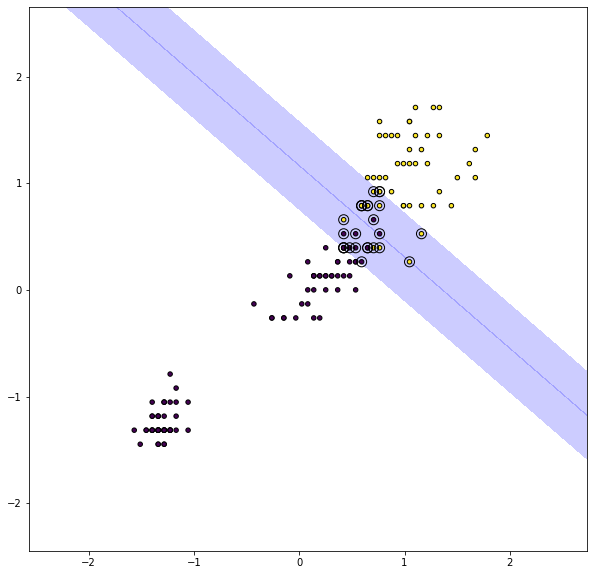

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

scale=StandardScaler()
X_scale=scale.fit_transform(petal_len_wid)

svm_lin1=SVC(kernel='linear', C=1)
svm1=svm_lin1.fit(X_scale, y_virginica)

# when C is 1
SVM_region(X_scale, y_virginica, svm1, svc=True)

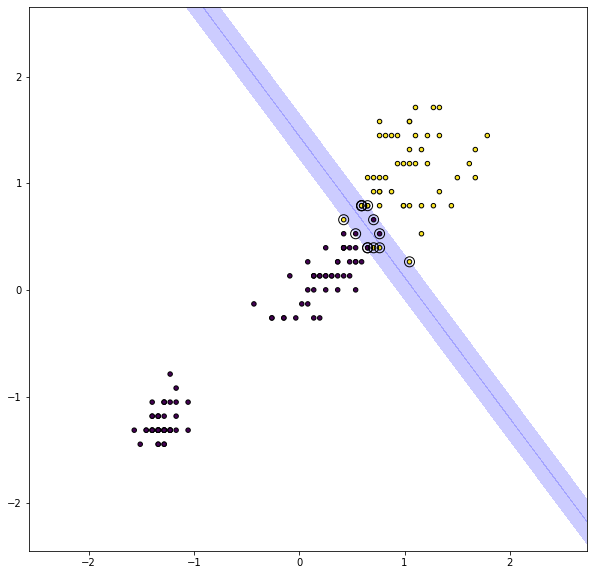

In [47]:
svm_lin2=SVC(kernel='linear', C=50)
svm2=svm_lin2.fit(X_scale, y_virginica)

# when C is 50
SVM_region(X_scale, y_virginica, svm2, svc=True)

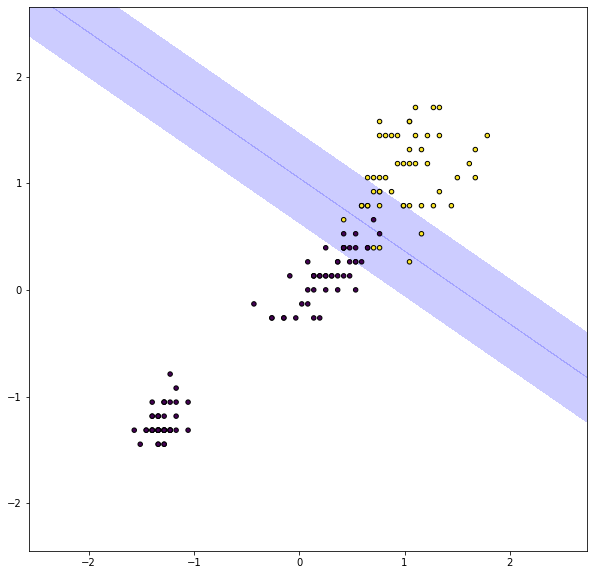

In [48]:
# an emxaple of LinearSVC
svm_lin=LinearSVC(penalty='l2', loss='hinge', C=1)
svm=svm_lin.fit(X_scale, y_virginica)
SVM_region(X_scale, y_virginica, svm)

### Nonlinear SVM- Kernel Trick

__Gaussian RBF Kernel__:

Increasing $\gamma$ makes the decision boundary ends up being more irregular, wiggling around individual instances. Conversely, a small $\gamma$ makes the decision boundary smooth. Similar to $C$, $\gamma$ acts like a regularization hyperparameter- if your model is overfitting, you should reduce $\gamma$.

__Polynomial Kernel__:

It works like adding polynomial features. A high polynomial degree can deal with complex data but easily get overfitting. Another parameter `coef0` controls how much the model is influenced by high-degree polynomials compared to low-degree polynomials, it sets to 0 by default.


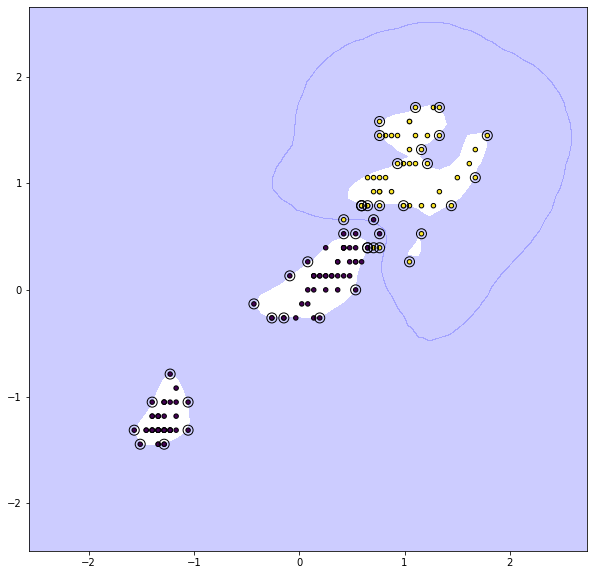

In [49]:
svm_nonlin1=SVC(kernel='rbf', gamma=10, C=1)
svm_rbf1=svm_nonlin1.fit(X_scale, y_virginica)

# rbf kernel: gamma=5, C=1
SVM_region(X_scale, y_virginica, svm_rbf1, svc=True)

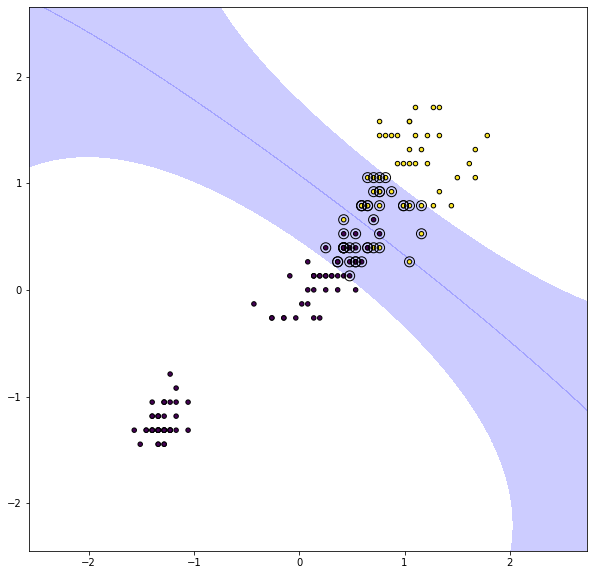

In [50]:
svm_nonlin2=SVC(kernel='rbf', gamma=0.1, C=1)
svm_rbf2=svm_nonlin2.fit(X_scale, y_virginica)

# rbf kernel: gamma=0.1, C=1
SVM_region(X_scale, y_virginica, svm_rbf2, svc=True)

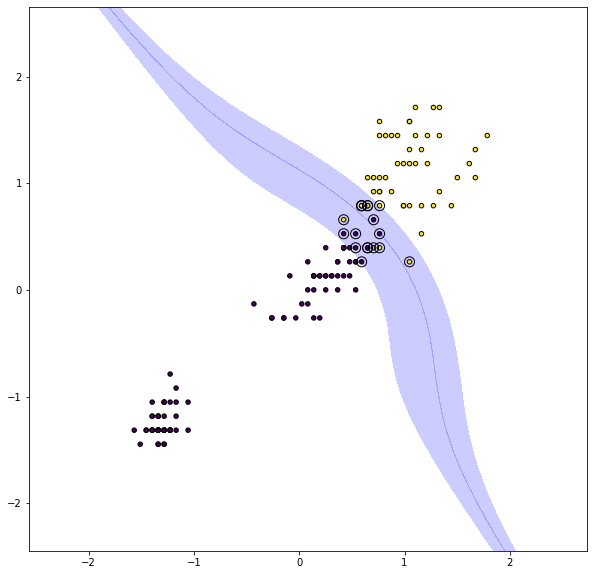

In [51]:
svm_nonlin3=SVC(kernel='poly', degree=3, gamma=1)
svm_poly1=svm_nonlin3.fit(X_scale, y_virginica)

# poly kernel: degree=3, coef0=1
SVM_region(X_scale, y_virginica, svm_poly1, svc=True)

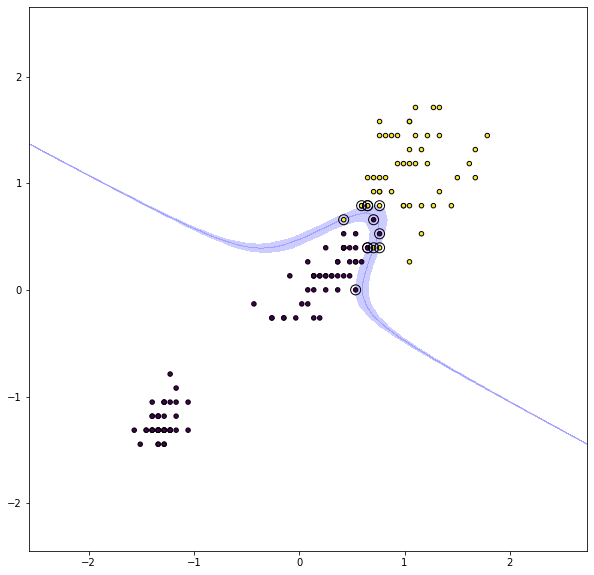

In [52]:
svm_nonlin4=SVC(kernel='poly', degree=3, gamma=10)
svm_poly2=svm_nonlin4.fit(X_scale, y_virginica)

# poly kernel: degree=3, coef0=10
SVM_region(X_scale, y_virginica, svm_poly2, svc=True)